In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from yolov7.distillate import create_optimizer
from yolov7.utils.general import one_cycle



In [9]:
class Args:
    adam = False
    batch_size = 64
args = Args()
model = nn.Sequential(nn.Linear(10,10), nn.BatchNorm2d(10))
hyp = {
    "weight_decay": 0.0005,
    "momentum": 0.9,
    "lr0": 0.007,
    "lrf": 0.1,
    "warmup_epochs": 3,
    "warmup_momentum": 0.8,
    "warmup_bias_lr": 0.1
}
optimizer = create_optimizer(args, model, hyp)
lf = one_cycle(1, hyp["lrf"], 30)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
nw = round(hyp["warmup_epochs"] * 10)

Optimizer groups: 2 .bias, 1 conv.weight, 1 other


In [10]:
lrs = []
for i in range(30):
    for j in range(10):
        ni = (
            j + 10 * i
        )
        if ni <= nw:
            xi = [0, nw]  # x interp
            # model.gr = np.interp(ni, xi, [0.0, 1.0])  # iou loss ratio (obj_loss = 1.0 or iou)
            accumulate = max(
                1, np.interp(ni, xi, [1, 64 / args.batch_size]).round()
            )
            for j, x in enumerate(optimizer.param_groups):
                # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                x["lr"] = np.interp(
                    ni,
                    xi,
                    [
                        hyp["warmup_bias_lr"] if j == 2 else 0.0,
                        x["initial_lr"] * lf(i),
                    ],
                )
                if "momentum" in x:
                    x["momentum"] = np.interp(
                        ni, xi, [hyp["warmup_momentum"], hyp["momentum"]]
                    )
    lr = [x["lr"] for x in optimizer.param_groups]  # for tensorboard
    scheduler.step()
    lrs.append(lr)

# plot lrs


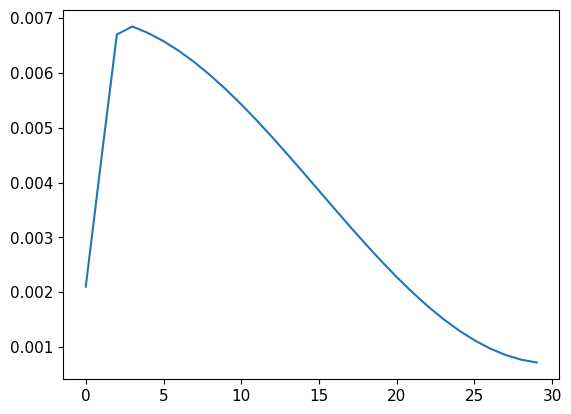

In [11]:
%matplotlib inline
plt.plot(np.array(lrs)[:, 0])
plt.show()